In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleUnet(nn.Module):
    def __init__(self):
        super(SimpleUnet, self).__init__()

        # Down conv
        self.down_conv1 = nn.Sequential(
            nn.Conv2d(3, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(2, 2)
        self.down_conv2 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(2, 2)
        self.down_conv3 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.pool3 = nn.MaxPool2d(2, 2)
        self.down_conv4 = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )

        # Up conv
        self.up_conv1 = nn.Sequential(
            nn.Conv2d(96, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.up_conv2 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.up_conv3 = nn.Sequential(
            nn.Conv2d(768, 1, kernel_size=3, padding=1),
            nn.BatchNorm2d(1),
            nn.ReLU()
        )

    def forward(self, x):
        # Downsample
        x1 = F.relu(self.down_conv1(x))
        x1p = self.pool1(x1)
        x2 = F.relu(self.down_conv2(x1p))
        x2p = self.pool2(x2)
        x3 = F.relu(self.down_conv3(x2p))
        x3p = self.pool3(x3)
        x4 = F.relu(self.down_conv4(x3p))

        # Upsample
        x5u = F.interpolate(x4, scale_factor=2, mode='bilinear', align_corners=False)
        x5c = torch.cat([x5u, x3], dim=1)
        x6 = F.relu(self.up_conv1(x5c))
        x6u = F.interpolate(x6, scale_factor=2, mode='bilinear', align_corners=False)
        x6c = torch.cat([x6u, x2], dim=1)
        x7 = F.relu(self.up_conv2(x6c))
        x7u = F.interpolate(x7, scale_factor=2, mode='bilinear', align_corners=False)
        x7c = torch.cat([x7u, x1], dim=1)

        x8 = F.relu(self.up_conv3(x7c))

        x_out = torch.sigmoid(x8)
        return x_out

In [11]:
import os
import torch


device = torch.device('cpu')

model = SimpleUnet()

cwd = os.getcwd()

state_dictionary = torch.load(f'{cwd}/backups/epoch99.pth')

model.load_state_dict(state_dictionary)
model.eval()

model.to(device)

SimpleUnet(
  (down_conv1): Sequential(
    (0): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down_conv2): Sequential(
    (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down_conv3): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down_conv4): Sequential(
    (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), pa

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8233846..1.9011732].


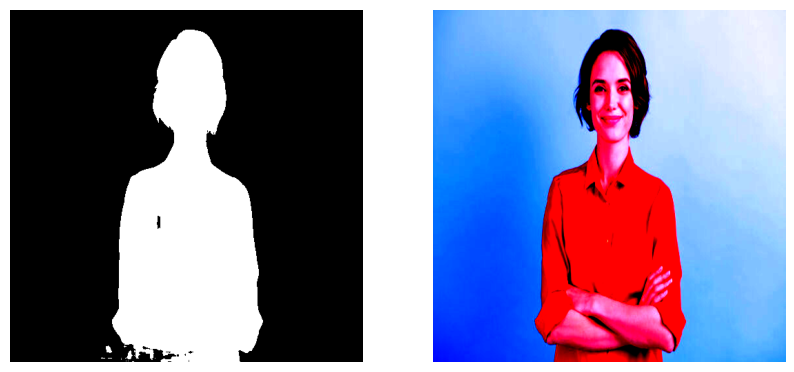

In [12]:
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import torch

def plot(mask, image):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    mask_np = mask.squeeze().cpu().detach().numpy()
    image_np = image.squeeze().cpu().detach().numpy().transpose(1, 2, 0)
    
    axs[0].imshow(mask_np, cmap='gray')
    axs[0].axis('off')

    axs[1].imshow(image_np)
    axs[1].axis('off')

    plt.show()

image_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(torch.tensor([0.4117, 0.5926, 0.3815]), [0.3299, 0.3250, 0.3212]) # Values calculated in model.ypynb
])

def load_image(path):
    image = Image.open(path).convert('RGB')
    image_tensor = image_transform(image).float()
    image_tensor = image_tensor.unsqueeze(0)
    image_tensor.to(device)
    return image_tensor

image = load_image(f'{cwd}/stock1.jpg')

output = model(image) > 0.5

plot(output, image)

